In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
import random
import sys
import time
import zlib

In [3]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from scipy.stats import ttest_1samp

#### Datasets

In [4]:
### Users
path = '../../bot-dna-compression/datasets_full.csv/datasets_full.csv/'
# Genuine accounts.
gen = pd.read_csv(path+'genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv(path+'social_spambots_1.csv/users.csv')
ss2 = pd.read_csv(path+'social_spambots_2.csv/users.csv')
ss3 = pd.read_csv(path+'social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv(path+'traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv(path+'traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv(path+'traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv(path+'traditional_spambots_4.csv/users.csv')

In [5]:
### Tweets
# Genuine accounts.
gen_tweets = pd.read_csv(path+'genuine_accounts.csv/tweets.csv', sep=",",encoding="latin-1")

# Social spambots.
ss1_tweets = pd.read_csv(path+'social_spambots_1.csv/tweets.csv', sep=",",encoding="latin-1")
ss2_tweets = pd.read_csv(path+'social_spambots_2.csv/tweets.csv', sep=",",encoding="latin-1")
ss3_tweets = pd.read_csv(path+'social_spambots_3.csv/tweets.csv', sep=",",encoding="latin-1")

# Traditional spambots.
ts1_tweets = pd.read_csv(path+'traditional_spambots_1.csv/tweets.csv',sep=",",encoding="latin-1")

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Digital DNA

In [6]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [7]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

In [8]:
gen_dna = create_dna_from_tweets(gen_tweets)

ss1_dna = create_dna_from_tweets(ss1_tweets)
ss2_dna = create_dna_from_tweets(ss2_tweets)
ss3_dna = create_dna_from_tweets(ss3_tweets)

ts1_dna = create_dna_from_tweets(ts1_tweets)

In [9]:
gen_dna = compress_dna_df(gen_dna)

ss1_dna = compress_dna_df(ss1_dna)
ss2_dna = compress_dna_df(ss2_dna)
ss3_dna = compress_dna_df(ss3_dna)

ts1_dna = compress_dna_df(ts1_dna)

bot_dna = pd.concat([ss1_dna, ss2_dna, ss3_dna,ts1_dna])

In [10]:
# Add a column for account type to the dataframes.
gen_dna['Account Type'] = 'Genuine'
bot_dna['Account Type'] = 'Bot'

# Combine all samples into a single dataframe.
all_dna = pd.concat([gen_dna, bot_dna])

#### Compression statistics 

In [11]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = all_dna['Account Type'] == 'Genuine'
b = all_dna['Account Type'] == 'Bot'

In [12]:

compression_stats = pd.DataFrame({'Mean Length': [all_dna['dna'].apply(len).mean(), 
                                                  all_dna[g]['dna'].apply(len).mean(), 
                                                  all_dna[b]['dna'].apply(len).mean()],
                                  'SD Length': [all_dna['dna'].apply(len).std(), 
                                                all_dna[g]['dna'].apply(len).std(), 
                                                all_dna[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [all_dna['original_dna_size'].mean(), 
                                                             all_dna[g]['original_dna_size'].mean(), 
                                                             all_dna[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [all_dna['original_dna_size'].std(), 
                                                            all_dna[g]['original_dna_size'].std(), 
                                                           all_dna[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [all_dna['compressed_dna_size'].mean(), 
                                                           all_dna[g]['compressed_dna_size'].mean(), 
                                                           all_dna[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [all_dna['compressed_dna_size'].std(), 
                                                         all_dna[g]['compressed_dna_size'].std(), 
                                                         all_dna[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [all_dna['compression_ratio'].mean(), 
                                                            all_dna[g]['compression_ratio'].mean(), 
                                                            all_dna[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [all_dna['compression_ratio'].std(), 
                                                          all_dna[g]['compression_ratio'].std(), 
                                                          all_dna[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot']).round

####  Compression statistics visualization

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


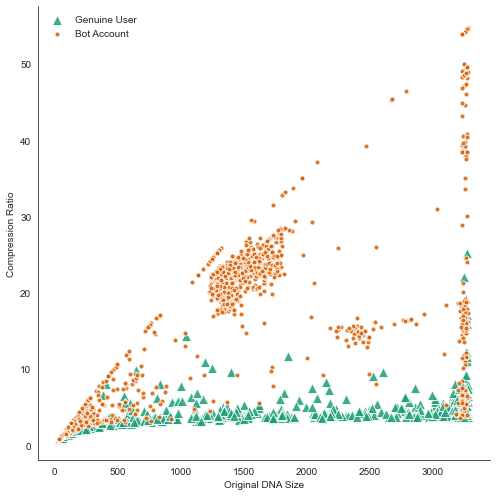

In [13]:
sns.set_style("white")

pal = {
    'Genuine': sns.color_palette('Dark2')[0],
    'Bot':  sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=7, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=100, alpha=.85, edgecolor="white")
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
plt.legend(loc='upper left', frameon=False,labels=['Genuine User', 'Bot Account'])
g.savefig('cresci_scatter.svg')

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


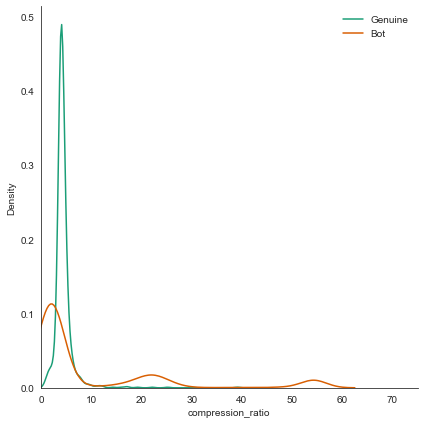

In [14]:

g = sns.FacetGrid(all_dna, hue='Account Type', palette=pal, size=6)
g.set(xlim=(0, 75))
g.map(sns.kdeplot, 'compression_ratio')
# g.add_legend()
plt.legend(loc='upper right', frameon=False)
g.savefig('cresci_KDE.svg')

In [15]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

In [21]:
def train_predict_evaluate(classifier, dna, features, test_size=0.3):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

In [25]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)


# DNA string compression for genuine accounts in test set 1.
gen_dna_test1 = compress_dna_df(gen_dna_test1)

# DNA string compression for spambots in test set 1.
ss1_dna_test1 = compress_dna_df(ss1_dna_test1)


# Add a column for label to the dataframes.
gen_dna_test1['label'] = 0
ss1_dna_test1['label'] = 1

<ipython-input-6-e60acc576c99>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
<ipython-input-6-e60acc576c99>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
<ipython-input-6-e60acc576c99>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [26]:
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]

gen_with_no_tweets_dna_test1 = pd.DataFrame({'id': gen_with_no_tweets_test1['id'], 
                                             'original_dna_size': 33, 
                                             'compressed_dna_size': 41, 
                                             'compression_ratio': 0.80, 
                                             'label': 0})

gen_with_no_tweets_dna_test1 = gen_with_no_tweets_dna_test1.set_index('id')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

# Combine test set 1 accounts into a single dataframe.
dna_test1 = pd.concat([gen_dna_test1, ss1_dna_test1])

In [27]:
rf_classifier = RandomForestClassifier(bootstrap=True,max_depth=5)
train_predict_evaluate(rf_classifier,dna_test1,['original_dna_size', 'compressed_dna_size'])

,Metric,Score
0,Accuracy,0.991639
1,Precision,1.000000
2,Recall,0.982014
3,F1 Score,0.990926
4,MCC,0.983314
5,Specificity,1.000000


In [29]:
train_predict_evaluate(rf_classifier,dna_test1,['original_dna_size', 'compression_ratio'])

,Metric,Score
0,Accuracy,0.981605
1,Precision,0.979592
2,Recall,0.982935
3,F1 Score,0.981261
4,MCC,0.963204
5,Specificity,0.980328


In [31]:

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)


NameError: name 'GradientBoostingClassifier' is not defined

In [30]:
train_predict_evaluate(gb_classifier,ds,['original_dna_size', 'compressed_dna_size'])

NameError: name 'gb_classifier' is not defined